# Soma Detection Analysis of Whole-Brain Light-Sheet Images

In [10]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.analyze_results import SomaDistribution
from brainlit.BrainLine.util import (
    json_to_points,
    download_subvolumes,
)
from brainlit.BrainLine.apply_ilastik import (
    ApplyIlastik,
    ApplyIlastik_LargeImage,
    plot_results,
    examine_threshold,
)
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from cloudreg.scripts.transform_points import NGLink
from brainlit.BrainLine.imports import *
from scipy.stats import chi2_contingency
from scipy.special import rel_entr
from itertools import combinations
import networkx as nx
import random
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind

%gui qt5

## 1. Before Using this notebook

### 1a. Install brainlit, and other packages that this notebook uses
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --input_parent_dir /mnt/NAS/SmartSPIM_Data/2023_11_21/20231121_15_12_04_MS50_Stained_destriped_DONE/ --s3_output_parent_dir  s3://smartspim-precomputed-volumes/2023_11_21/MS50/  --local_output_parent_dir "precomputed://file:///mnt/data/Neuroglancer_Data/2023_11_21/MS50/" --voxel_size 1.83 1.83 2 --num_procs 72 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
    ,
    {
    "type":"pointAnnotation",
    "name": "soma_val",
    "points": []
    },
    {
    "type":"pointAnnotation",
    "name": "nonsoma_val",
    "points":[]
    }
### 1d. Update soma_data.py file

### \* Inputs \*

In [11]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[1]
print(f"Path to brainlit: {brainlit_path}")
data_file = brainlit_path / "experiments" / "BrainLine" / "data" / "soma_data.json"

with open(data_file) as f:
    data = json.load(f)
brain2paths = data["brain2paths"]

brain = "MS50_v2"  # brain ID
soma_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"  # path to directory where training/validation data should be stored

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit


## 2. Download benchmark data

### \*Inputs\*

In [3]:
dataset_to_save = "val"  # train or val

#"zero" to fill the layer with zeros
antibody_layer = "Ch_647" # "Ch_647" 
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

### Setup paths

In [4]:
cvol_base = brain2paths[brain]["base_s3"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

### Download data

In [5]:
download_subvolumes(
    soma_data_dir,
    brain_id=brain,
    layer_names=layer_names,
    dataset_to_save=dataset_to_save,
    data_file=data_file,
)

Ch_647 shape: (7460, 10315, 4309, 1) at [1830. 1830. 2000.]
Ch_561 shape: (7460, 10315, 4309, 1) at [1830. 1830. 2000.]
Ch_488 shape: (7460, 10315, 4309, 1) at [1830. 1830. 2000.]
[10, 10] centers
Downloaded data will be stored in /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val


Saving samples: 100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainr2/val/891_4202_1717_pos.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_fg = pred[0, :, :, :]
    image_bg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply ilastik to validation data

You can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

### \* Inputs \*

In [6]:
model = "_rabies_pix_3ch"
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma{model}.ilp"  # path to ilastik model to be used
dset = "val"
ilastik_path = (
    "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
)
brains_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"
brains = [brain]

In [7]:
applyilastik = ApplyIlastik(
    ilastik_path=ilastik_path,
    project_path=project_path,
    brains_path=brains_path,
    brains=brains,
)
applyilastik.process_subvols(dset = dset, ncpu=2)
# applyilastik.move_results()

Gathering brains...:   0%|          | 0/1 [00:00<?, ?it/s]

Applying ilastik to ['/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/3730_4363_1711_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/4543_5457_1693_neg.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/5458_5356_1717_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/4389_7499_2301_neg.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/2941_3553_1424_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/1297_5041_1174_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/4191_3469_1591_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/2034_2459_1687_pos.h5', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/2358_4968_922

running ilastik...: 100%|██████████| 2/2 [00:00<00:00, 37.44it/s]


Gathering brains...: 100%|██████████| 1/1 [01:58<00:00, 118.20s/it]


### \*Inputs (if relevant)\*
- identify files that have two somas in variable below. Since voxel coordinates are likely to be unique across samples, the file names below do not include sample IDs.

In [8]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
    "2589_5825_1626_pos_Probabilities.h5",
    "2138_4233_2329_pos_Probabilities.h5",
    "2545_6206_1551_pos_Probabilities.h5",
    "2568_6047_1553_pos_Probabilities.h5",
    "2547_6082_1541_pos_Probabilities.h5",
    "3010_5734_1340_pos_Probabilities.h5",
    "5458_5532_2463_pos_Probabilities.h5",
    "3669_4378_1341_pos_Probabilities.h5",
    "2855_4063_1834_pos_Probabilities.h5",
    "4579_6656_2509_pos_Probabilities.h5"
]  # move 2545?

## 5. Check Results

Processing Brains: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


If this performance is not adequate, improve model and try again
Brain MS50_v2 Validation: 10+ 10-


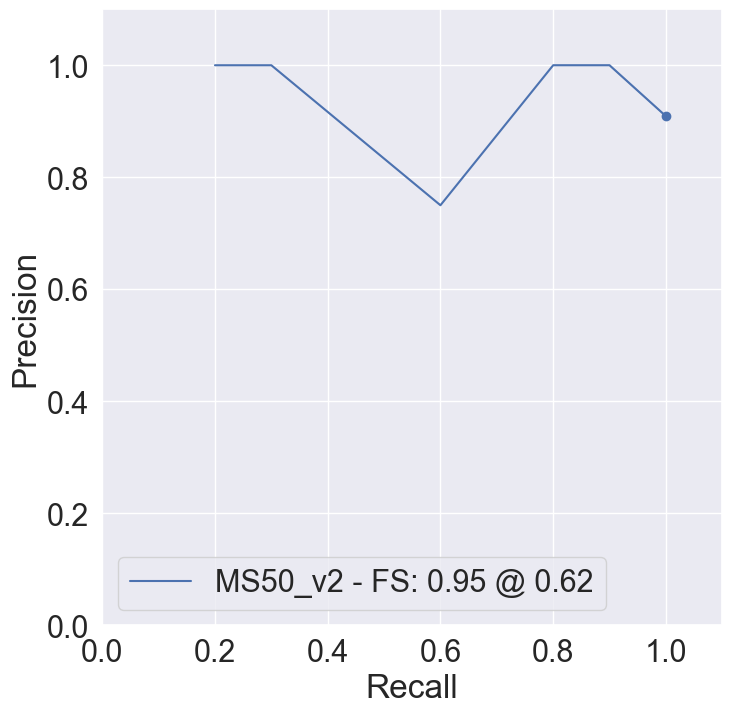

In [9]:
plot_results(
    data_dir=soma_data_dir,
    brain_ids=brains,
    object_type="soma",
    positive_channel=0,
    dset = dset,
    doubles=doubles,
)
plt.show()

In [8]:
examine_threshold(
    data_dir=soma_data_dir,
    brain_id=brain,
    threshold=0.62,
    object_type="soma",
    positive_channel=0,
    dset = dset,
    doubles=doubles,
)

*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/3730_4363_1711_pos.h5*********
area of detected object: 671
area of detected object: 614
Soma false positive Area: 614
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/4543_5457_1693_neg.h5*********
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/5458_5356_1717_pos.h5*********
area of detected object: 2259
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/4389_7499_2301_neg.h5*********
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/2941_3553_1424_pos.h5*********
area of detected object: 1176
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/val/1297_5041_1174_pos.h5*********
area of detected object: 1104
************

### Paper figure for all validation

In [ ]:
brain_ids = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    "r1",
    "r2",
    "8446",
    "8454",
    "887",
    "MPRRabies",
    "969",
    "910",
]

plot_results(
    data_dir=soma_data_dir,
    brain_ids=brain_ids,
    object_type="soma",
    positive_channel=0,
    doubles=doubles,
)

## 6. Make Annotation layers

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image

### \* Inputs \*
You can use the notebook code below or the script using `soma_detect_image.py`

In [ ]:
brain = "test"
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

threshold = 0.28  # threshold to use for ilastik
data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_temp/"  # "/data/tathey1/matt_wright/brainr_temp/"  # directory to store temporary subvolumes for segmentation
results_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/"  # directory to store coordinates of soma detections

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"  # "/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma_rabies_pix_3ch.ilp"  # "/data/tathey1/matt_wright/ilastik/soma_model/matt_soma_rabies_pix_3ch.ilp"  # path to ilastik project

max_coords = [3072, 4352, 1792]  # -1 if you want to process the whole dimension
ncpu = 1  # 16  # number of cores to use for detection
chunk_size = [256, 256, 256]  # [256, 256, 300]

In [ ]:
layer_names = [antibody_layer, background_layer, endogenous_layer]

ilastik_largeimage = ApplyIlastik_LargeImage(
    ilastik_path=ilastik_path,
    ilastik_project=ilastik_project,
    results_dir=results_dir,
    ncpu=1,
)
ilastik_largeimage.apply_ilastik_parallel(
    brain_id=brain,
    layer_names=layer_names,
    threshold=threshold,
    data_dir=data_dir,
    chunk_size=chunk_size,
    max_coords=max_coords,
)
ilastik_largeimage.collect_results(brain_id="test")

## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 

A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [0,0,0], "PIR", "RPI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_11_21/MS50/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_11_21/MS50/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RAI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.0 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_11_21/MS50/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform data to atlas space using CloudReg

### Soma coordinates

```
python -m cloudreg.scripts.transform_points --target_viz_link "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=Fy1xF8FlJM7BcQ" --atlas_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg" --affine_path /mnt/NAS/Neuroglancer\ Data/2023_04_25/MS22/MS22_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2023_04_25/MS22/MS22_Ch_561_registration/downloop_1_v.mat --transformation_direction "atlas"
```

or

local + viz link:
```
python -m cloudreg.scripts.transform_points --target_viz_link "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=pGU9q_wX4vpxLg" --atlas_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg" --affine_path /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/MS50_Ch_561_registration/downloop_1_A.mat --velocity_path /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS50_v2/MS50_Ch_561_registration/downloop_1_v.mat  --transformation_direction atlas
```

or

local + json file:
```
python -m cloudreg.scripts.transform_points --target_viz_link /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS22/MS22_Ch_561_registration/state.json --atlas_viz_link /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/BrainLine/data/ara-state.json --affine_path /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS22/MS22_Ch_561_registration/downloop_1_A.mat --velocity_path /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS22/MS22_Ch_561_registration/downloop_1_v.mat --transformation_direction atlas --soma_path /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/all_somas_MS22.txt
```

This will produce a neuroglancer link with the transformed soma coordinates, which should be added to `soma_data.py` under the `somas_atlas_url` key. Then the code below, or `soma_brainrender.py`, can be used to visualize the data.

### Image

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561_transformed --affine_path /cis/home/tathey/887_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/887_Ch_561_registration/downloop_1_v.mat
```

or

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/969_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/969_Ch_561_registration/downloop_1_v.mat
```

## 9. View results in brain space

### \*Inputs\*

In [45]:
brain_ids = [
    "8557", # before aug 2022,
    "8555", # before aug 2022
    "8607", # before aug 2022
    "8606", # before aug 2022
    # "8477",
    # "8531",
    "8608", # before aug 2022
    # "8529",
    # "8454",
    "MPRRabies",
    "969",
    "892",
    "MS37", 
    "MS36",
    "MS25",
    "MS23", 
    "MS22", 
    "MS50",
    "MS39",
    "MS21"
]

# brain_ids = ["MS50", "MS50_v2"]

colors = {
    "tph2 vglut3": "blue",
    "tph2 gad2": "red",
    "gad2 vgat": "green",
}  # colors for different genotypes
symbols = ["arrow", "clobber", "cross", "diamond", "disc", "hbar", "ring",
        "square", "star", "tailed_arrow", "triangle_down", "triangle_up", "vbar", "x"]
fold_on = False
ontology_file = brainlit_path / "BrainLine" "data" / "ara_structure_ontology.json"

sd = SomaDistribution(
    brain_ids=brain_ids, data_file=data_file, ontology_file=ontology_file,
    bootstrap=0, shuffle=False
)

Brain 8557: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8557/transformed_points.json
Brain 8555: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8555/transformed_points.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points1.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points0.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points6.json
Brain 8607: Collecting atlas space soma points from file: /Users/th

Finding soma regions of brains: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s]


In [ ]:
sd.napari_coronal_section(
        z=800, subtype_colors=colors, symbols=symbols, fold_on=True
    )

In [ ]:
z_size = 1320
for z in tqdm(np.arange(250, z_size, 250)):
    sd.napari_coronal_section(
        z=z, subtype_colors=colors, symbols=symbols, fold_on=True
    )

In [ ]:
dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/matt-coronals/"
z_size = 1320

for z in tqdm(np.arange(50, z_size, 50)):
    fname = dir + f"{brain}_{z}.tif"
    v = sd.napari_coronal_section(
        z=z, subtype_colors=colors, symbols=symbols, fold_on=False
    )
    im = v.screenshot(canvas_only=False)
    io.imsave(fname, im)

In [ ]:
sd.brainrender_somas(subtype_colors=colors)

### DCorr test

In [ ]:
sd.dcorr_test(subtype1 = "tph2 gad2", subtype2 = "tph2 vglut3", bin_size = [250,250,250])
sd.dcorr_test(subtype1 = "tph2 gad2", subtype2 = "gad2 vgat", bin_size = [250,250,250])
sd.dcorr_test(subtype1 = "gad2 vgat", subtype2 = "tph2 vglut3", bin_size = [250,250,250])

### Cluster Perm Test

In [ ]:
brain2paths = sd.brain2paths

if "filepath" in brain2paths["atlas"].keys():
    vol_atlas = io.imread(brain2paths["atlas"]["filepath"])

In [ ]:
from itertools import combinations
from scipy.stats import ttest_ind
from skimage import measure

group0 = "tph2 gad2"
group1 = "tph2 vglut3"

block_sz = 500 # microns
props_shp = np.multiply(vol_atlas.shape, 10/block_sz).astype('int')

def partition_somas(id):
    props_mm = np.zeros(props_shp)
    points = sd.atlas_points[id]
    points = np.round(points*10 / block_sz).astype('int')
    for pt in points:
        if np.all(pt < props_shp):
            props_mm[pt[0], pt[1], pt[2]] += 1

    props_mm /= points.shape[0]
    return props_mm

ids = []
groups = []
props_mms = {}

for brain_id in sd.brain_ids:
    if sd.brain2paths[brain_id]["subtype"] == group0:
        ids.append(brain_id)
        groups.append(0)
        props_mms[brain_id] = partition_somas(brain_id)
    if sd.brain2paths[brain_id]["subtype"] == group1:
        ids.append(brain_id)
        groups.append(1)
        props_mms[brain_id] = partition_somas(brain_id)

combos = list(combinations(ids, np.sum(groups)))

def compute_stat(combo, return_stats=False, verbose=False):
    t_stats = np.zeros(props_shp)
    for ix, iy, iz in np.ndindex(t_stats.shape):
        sample0 = []
        sample1 = []
        for id in ids:
            if id in combo:
                sample1.append(props_mms[id][ix, iy, iz])
            else:
                sample0.append(props_mms[id][ix, iy, iz])
        result = ttest_ind(sample0, sample1)
        if result.pvalue < 0.05 and np.isfinite(result.statistic):
            if verbose:
                print(f"{(ix, iy, iz)}: {np.mean(sample0):.2e} vs {np.mean(sample1):.2e} stat: {result.statistic : .2e}")
            t_stats[ix,iy,iz] = result.statistic
    
    t_stats_pos = np.copy(t_stats)
    t_stats_pos[t_stats_pos <= 0] = 0
    t_stats_neg = np.copy(t_stats)
    t_stats_neg[t_stats_neg >= 0] = 0
    t_stats_neg *= -1

    sums = []
    for t_stats_side in [t_stats_pos, t_stats_neg]:
        labels, num = measure.label(t_stats_side > 0, return_num=True)
        for label in range(num):
            sums.append(np.sum(t_stats_side[labels == label]))

    if len(sums) == 0:
        stat = 0
    else:
        stat = np.amax(sums)

    if return_stats:
        return stat, t_stats
    else:
        return stat


stats = []
for combo in tqdm(combos):
    stats.append(compute_stat(combo))

combo_obs = [id for id, group in zip(ids, groups) if group == 1]
stat_obs, t_stats = compute_stat(combo_obs, return_stats=True, verbose=True)

pval = np.sum(stats > stat_obs)/len(stats)

fig, ax = plt.subplots(1, 1)
ax.hist(stats)
ax.plot([stat_obs, stat_obs], [0, 20], c="r", label=f"pval={pval:.2f}")
ax.set_title(f"{group0} vs {group1} w/{len(combos)} permutations")
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(8)

In [ ]:
for brain in props_mms.keys():
    data = props_mms[brain]
    print(np.sum(data == 0)/data.size)
    fig, ax = plt.subplots(1, 1)
    ax.hist(data.flatten())
    plt.show()

In [ ]:
z = 1000

slice = np.squeeze(vol_atlas[z, :, :])  
newslice, borders, half_width = sd._slicetolabels(slice, fold_on=False)

v = napari.Viewer()
v.add_image(t_stats[int(z*10/block_sz),:,:], scale=[block_sz, block_sz], name=f"t-stat")

props_mms_0 = np.zeros(props_shp[1:])
props_mms_1 = np.zeros(props_shp[1:])

for id, group in zip(ids, groups):
    if group == 0:
        props_mms_0 += props_mms[id][int(z*10/block_sz),:,:]
    else:
        props_mms_1 += props_mms[id][int(z*10/block_sz),:,:]

props_mms_0 /= (len(ids) - np.sum(groups))
props_mms_1 /= np.sum(groups)

v.add_image(props_mms_0-props_mms_1, scale=[block_sz, block_sz], name=f"group 0 - group1 av")
v.add_labels(borders * 2, scale=[10, 10], name=f"atlas z={z}")

napari.run()

## 10. Display bar charts

In [46]:
regions_coarse_part = [ # 8 regions from Weissbound et al., 2014
    688, # cerebral cortex
    1097,
    549,
    354,
    512,
    477
]

regions_coarse = [
    688,
    1097,
    549,
    354,
    512,
    477,
    1089,
    313 # midbrain
]

regions_fine = [
    95,  # agranular insular area
    500, # somatomotor
    714,  # orbital area
    972,  # prelimbic
    453, # somatosensory
    44,  # infralimbic
    186,  # lateral habenula
    149, #paraventricular nucleus of thalamus (part of polymodal assoc cortex)
    864, # sensorimotor thalamus
    519, #cerebellar nuclei
    528, #cerebellar cortex
    290,  # hypothalamic lateral zone
    141, #periventricular region (preoptic nuclei)
    946, #posterior hypothalamic nucleus
    797,  # zona incerta
    331,  # mammillary body
    364, #parasubthalamic nucleus
    38, #paraventricular hypothalamic "nucleus
    223, #arcuate hypothalamic nucleus
    80, #anterior hypothal nucleus
    830, #dorsomedial hypothal nuc.
    693, #ventromedial hypothal nuc.
    470, #subthalamic n
    286, #suprachiasmatic n
    351,  # bed nuclei of stria terminalis
    536, #central amygdala
    323, #midbrain - motor
    339, #midbrain - sensory
    348, #midbrain - behavioral state
]

regions = [
    500, # somatomotor
    453, # somatosensory
    972,  # prelimbic
    44,  # infralimbic
    477,
    1089,
    1097, # hypothalamus
    549, # thalamus
    186,  # lateral habenula
    351,  # bed nuclei of stria terminalis
    313, # midbrain
    512, # cerebellum
    771, #pons
    354, # medulla
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdala": [131, 295, 319, 536, 780], #lateral, basolateral, basomedial, posterior
    # "Cortex (other)": [184, 1057, 677, 31, 254, 22, 541, 922, 895], # frontal pole, gustatory, visceral, auditory, visual, anterior cingulate, retrosplenial, posterior parietal, temporal association, perirhinal, ectorhinal
    #"Substantia Nigra": [615, 374, 374],
    #"Superior Colliculus": [294, 302],
}  # Custom composite allen regions where key is region name and value is list of allen regions

#### Are regions mutually exclusive?

In [ ]:
regions = regions_coarse_part
for r_src in regions:
    print(sd.region_graph.nodes[r_src]['name'])
    for r_targ in regions:
        if r_targ == r_src:
            continue
        elif nx.has_path(sd.region_graph, r_src, r_targ):
            print(f"{r_src} is parent of {r_targ}")

### Normality test

Zero detected in region 972 for subtype tph2 gad2
Zero detected in region 972 for subtype gad2 vgat
Zero detected in region 44 for subtype tph2 gad2
Zero detected in region 44 for subtype gad2 vgat


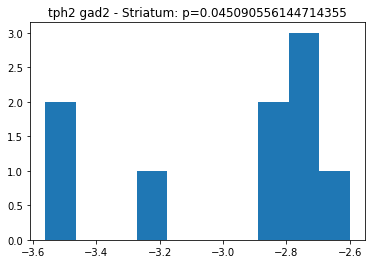

Zero detected in region 1089 for subtype tph2 gad2
Zero detected in region 1089 for subtype gad2 vgat
Zero detected in region 186 for subtype tph2 gad2
Zero detected in region 186 for subtype gad2 vgat


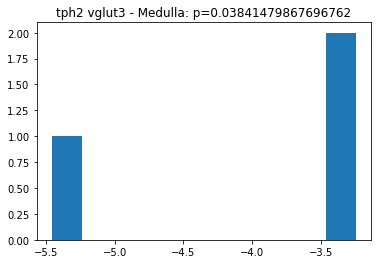

In [11]:
from scipy.stats import shapiro

DG = sd.region_graph

for region in regions:
    for subtype in colors.keys():
        data = []
        for brain in brain_ids:
            if brain2paths[brain]["subtype"] == subtype:
                total = DG.nodes[997][brain]
                data.append(np.log(DG.nodes[region][brain] / total))
                #data.append(DG.nodes[region][brain] / total)
        if np.any([ (not np.isfinite(d)) for d in data]):
            print(f"Zero detected in region {region} for subtype {subtype}")
        else:
            _, p = shapiro(data)
            if p < 0.05:
                plt.hist(data)
                plt.title(f"{subtype} - {DG.nodes[region]['name']}: p={p}")
                plt.show()
            

#### Simple boxplot

In [47]:
def _log_ttest_ind(group_data1, group_data2, verbose=1, **stats_params):
    group_data1_log = np.log(group_data1)
    group_data2_log = np.log(group_data2)

    return ttest_ind(group_data1_log, group_data2_log, **stats_params)

0 somas in region: Lateral habenula (186) for sample 8607 in group tph2 gad2
0 somas in region: Prelimbic area (972) for sample 8608 in group tph2 gad2
0 somas in region: Infralimbic area (44) for sample 8608 in group tph2 gad2
0 somas in region: Prelimbic area (972) for sample MS36 in group gad2 vgat
0 somas in region: Infralimbic area (44) for sample MS36 in group gad2 vgat
0 somas in region: Infralimbic area (44) for sample MS22 in group tph2 gad2
0 somas in region: Hippocampal formation (1089) for sample MS22 in group tph2 gad2
0 somas in region: Infralimbic area (44) for sample MS50 in group gad2 vgat
0 somas in region: Lateral habenula (186) for sample MS50 in group gad2 vgat
0 somas in region: Infralimbic area (44) for sample MS39 in group gad2 vgat
0 somas in region: Hippocampal formation (1089) for sample MS39 in group gad2 vgat


/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters pass

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Somatomotor areas_tph2 gad2 (n=9) vs. Somatomotor areas_gad2 vgat (n=4): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.662e-02 (ns) U_stat=3.400e+01
Somatomotor areas_tph2 vglut3 (n=3) vs. Somatomotor areas_tph2 gad2 (n=9): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.784e-01 U_stat=1.700e+01
Prelimbic area_tph2 gad2 (n=9) vs. Prelimbic area_gad2 vgat (n=4): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.030e-02 (ns) U_stat=3.250e+01
Prelimbic area_tph2 vglut3 (n=3) vs. Prelimbic area_tph2 gad2 (n=9): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.160e-02 (ns) U_stat=2.500e+01
Infralimbic area_tph2 gad2 (n=9) vs. Infralimbic area_gad2 vgat (n=4): Mann-Whitney-Wilcoxon tes

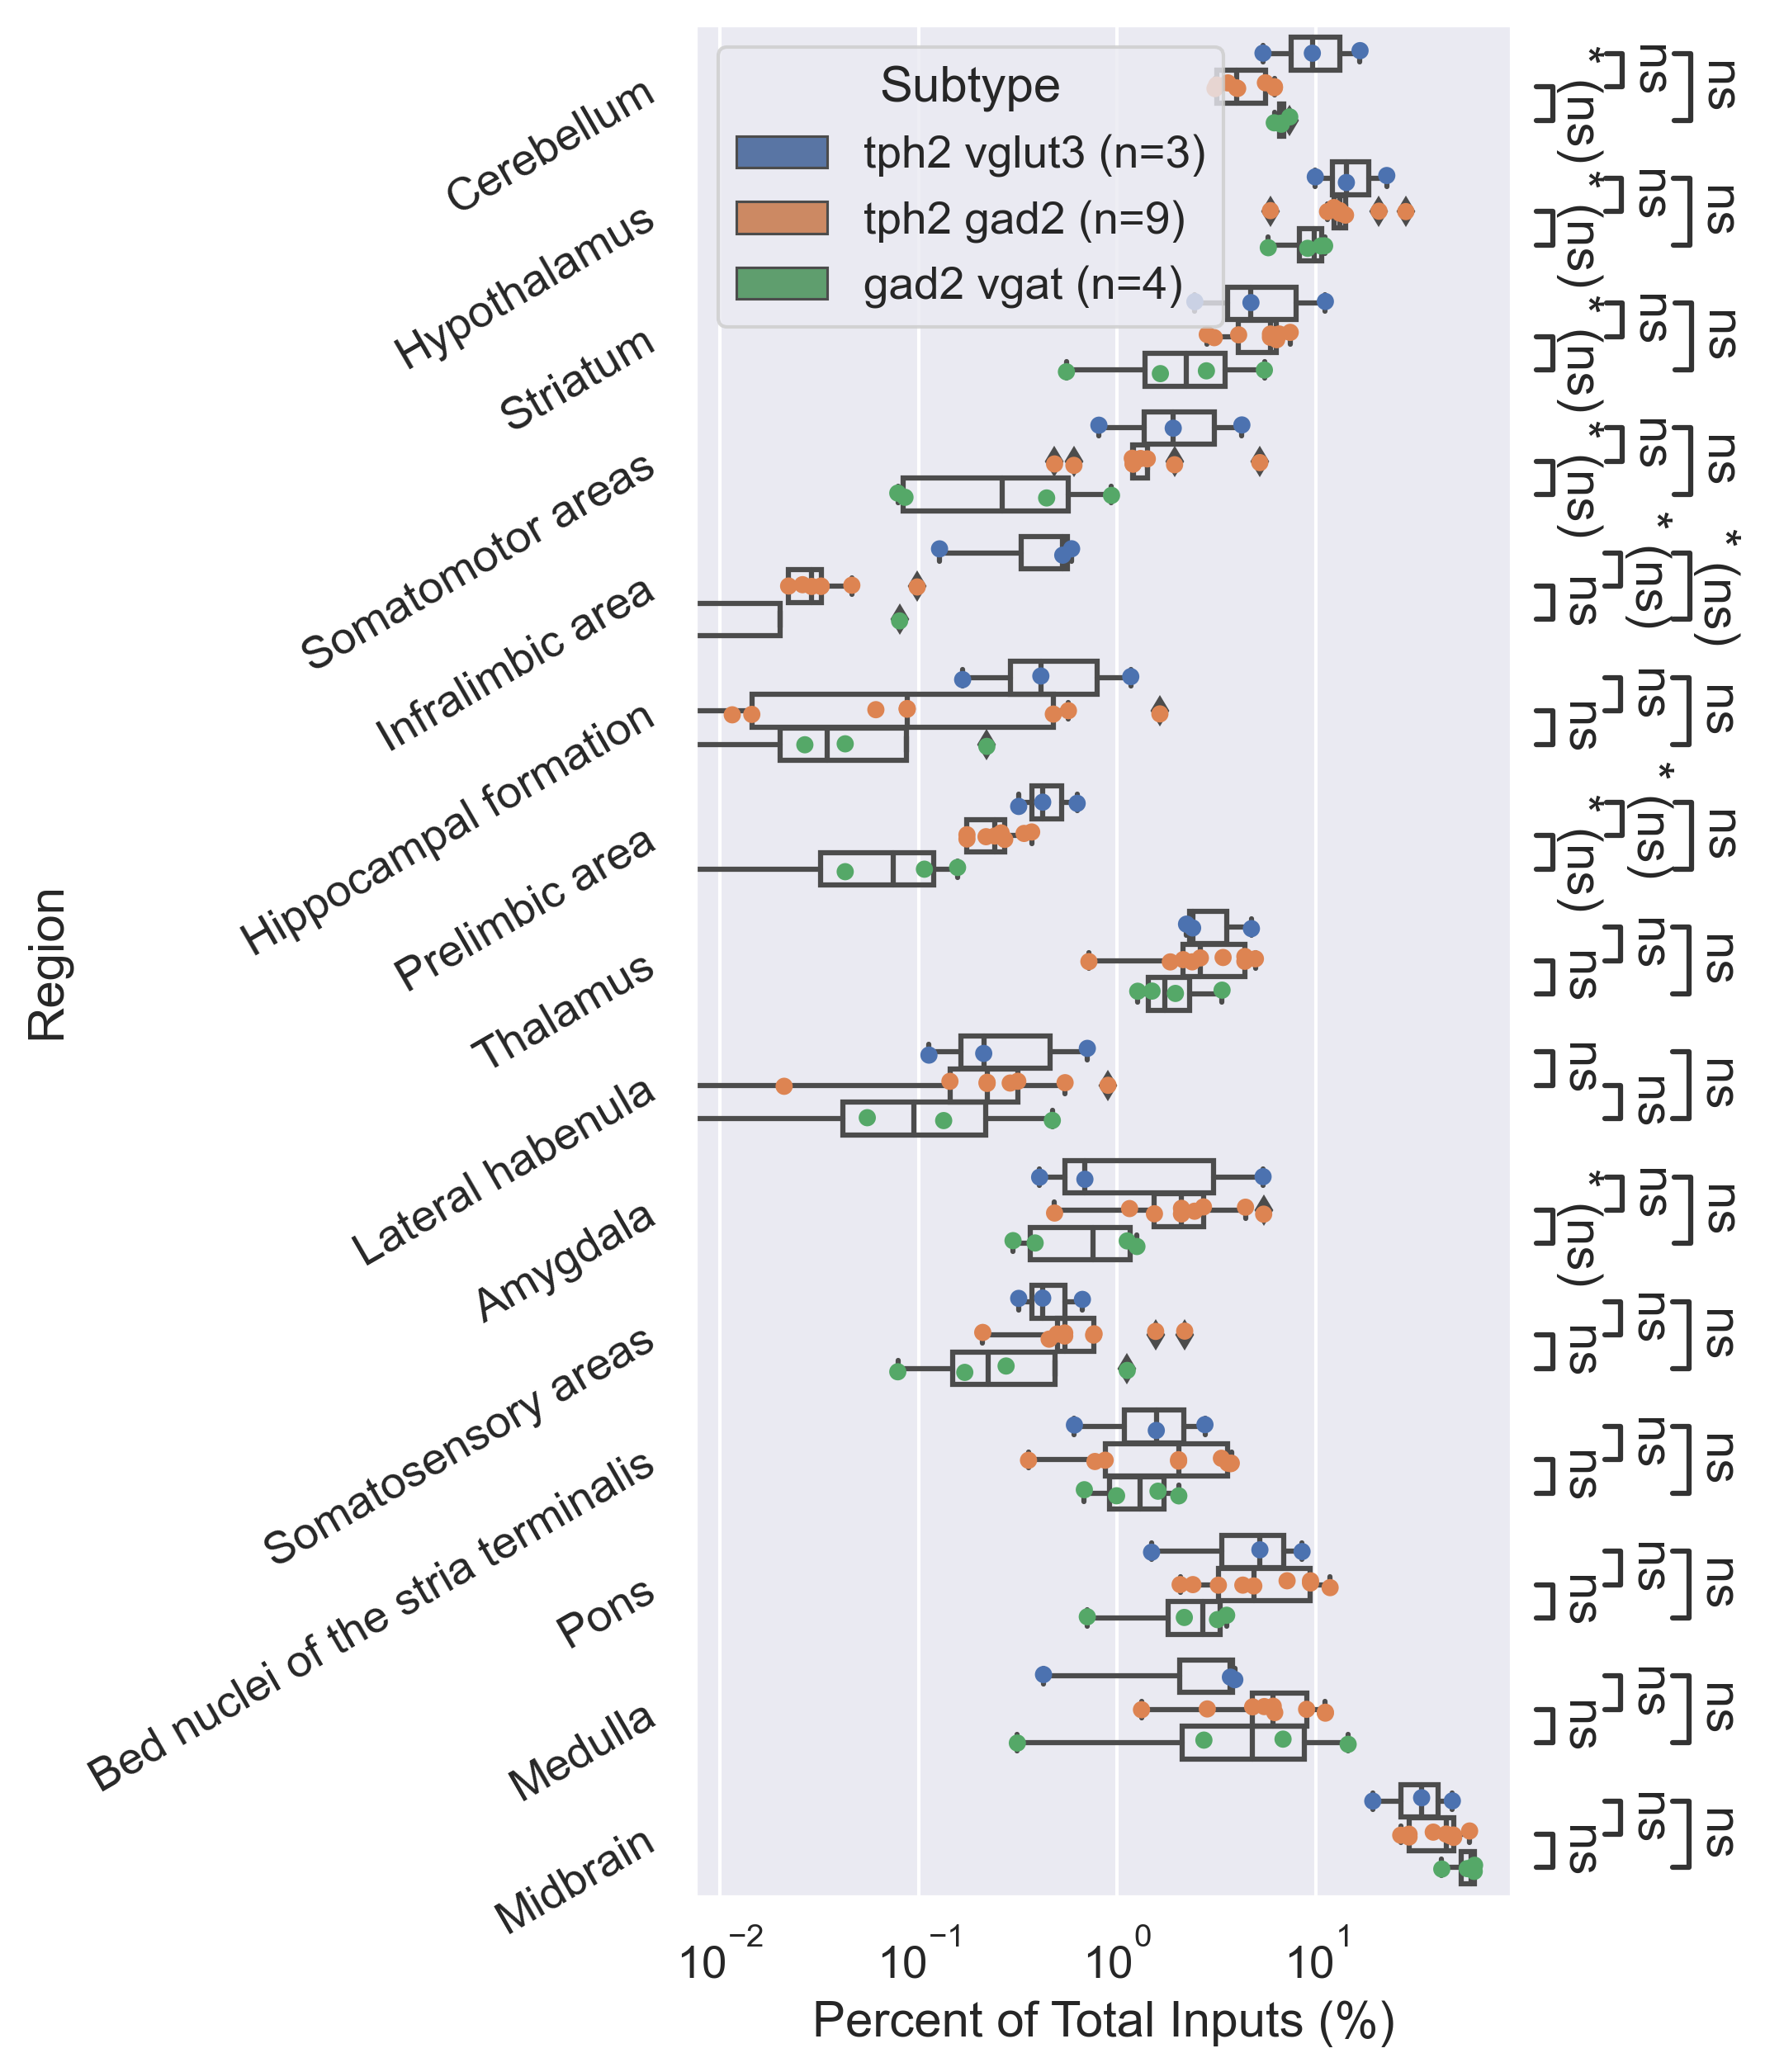

In [48]:
test = StatTest(_log_ttest_ind, test_long_name='Log t-test_ind', test_short_name='log-t')
test = "Mann-Whitney"
#test = "t-test_ind"
dep_var = "Percent of Total Inputs (%)"
pad = 0

region_names = []
pcts = []
counts = []
ids = []
subtypes = []
subtype_counts = {}

for brain_id in sd.brain_ids:
    subtype = sd.brain2paths[brain_id]["subtype"]
    if subtype in subtype_counts.keys():
        subtype_counts[subtype] = subtype_counts[subtype] + 1
    else:
        subtype_counts[subtype] = 1

    for region in regions:
        count = np.amax([pad,sd.region_graph.nodes[region][brain_id]])
        pct = count/sd.region_graph.nodes[997][brain_id]*100
        if pct == 0:
            print(f"0 somas in region: {sd.region_graph.nodes[region]['name']} ({region}) for sample {brain_id} in group {subtype}")
        pcts.append(pct)
        counts.append(sd.region_graph.nodes[region][brain_id])
        subtypes.append(subtype)
        ids.append(brain_id)
        region_names.append(sd.region_graph.nodes[region]["name"])
    for composite_region in composite_regions.keys():
        composite_region_regions = composite_regions[composite_region]
        total = 0
        for region in composite_region_regions:
            total += sd.region_graph.nodes[region][brain_id]
        pcts.append(total/sd.region_graph.nodes[997][brain_id]*100)
        counts.append(total)
        subtypes.append(subtype)
        ids.append(brain_id)
        region_names.append(composite_region)

# append n to subtypes
for i, subtype in enumerate(subtypes):
    subtypes[i] = subtype + f" (n={subtype_counts[subtype]})"


data = {"Region": region_names, "Brain ID": ids, "Subtype": subtypes, "Percent of Total Inputs (%)": pcts, "Total Somas": counts}
df = pd.DataFrame(data=data)


# bplot = sns.stripplot(x = "Total Somas", y = "Region", hue="Brain ID", data=df)
# bplot.set_xscale("log")
# plt.show()

diffs = []
for region_name in df["Region"].unique():
    diff = df[(df["Region"] == region_name) & (df["Subtype"] == f"tph2 gad2 (n={subtype_counts['tph2 gad2']})")][dep_var].mean() - df[(df["Region"] == region_name) & (df["Subtype"] == f"tph2 vglut3 (n={subtype_counts['tph2 vglut3']})")][dep_var].mean()
    diffs.append((region_name, diff))
def second(e):
    return e[1]
diffs.sort(key=second, reverse=False)
order = [e[0] for e in diffs]

sns.set(font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(8,8.6), dpi=300)
fig_args = {
            "x": dep_var,
            "y": "Region",
            "hue": "Subtype",
            "data": df,
            "dodge": True,
            "order": order
        }
bplot = sns.stripplot(ax=ax, legend=False, **fig_args)
fig_args["boxprops"] = {'facecolor':'none'}
bplot = sns.boxplot(ax=ax, **fig_args)

bplot.set_xscale("log")
xtick_labels = bplot.get_yticklabels()
bplot.set_yticklabels(labels=xtick_labels, rotation=30)

#annotator
fig_args["x"] = "Region"
fig_args["y"] = dep_var
pairs = []
unq_subtypes = np.unique(subtypes)
for region in regions + ["Amygdala"]:
    if region == "Amygdala":
        region_name = region
    else:
        region_name = sd.region_graph.nodes[region]["name"]

    for i, subtype1 in enumerate(unq_subtypes):
        for subtype2 in unq_subtypes[i+1:]:
            pairs.append(((region_name, subtype1), (region_name, subtype2)))
annot = Annotator(ax, pairs, **fig_args)
annot.configure(test=test, text_format="star", loc="outside", comparisons_correction="BH")
fig_args["y"] = "Region"
fig_args["x"] = dep_var
annot.new_plot(bplot, orient="h", plot="boxplot", **fig_args)
annot.apply_and_annotate()


# markers = ["o", "v", "^", "<", ">", "s", "p", "*", "+", "x", "D", "h", "H"]
# jitters = {"tph2 vglut3": -0.26, "tph2 gad2": 0, "gad2 vgat": 0.26}
# id2marker = {id: markers[idx] for idx, id in enumerate(brain_ids)}
# for idx, line in df.iterrows():
#     st = line["Subtype"].split("(")[0][:-1]

#     x = line["Percent of Total Inputs (%)"]
#     y = order.index(line["Region"]) + jitters[st]
#     c = colors[st]
#     marker = id2marker[line["Brain ID"]]
#     ax.scatter([x], [y], c=c, marker=marker)



fig.tight_layout()
plt.show()

## Compositional Data Analysis
- Means and variance
- PCA
- permutation test on distances between centers

In [67]:
def ilr(vector):
    y = np.zeros((len(vector)-1,))
    for im1, _ in enumerate(vector[:-1]):
        i = im1+1
        c = 1 / np.sqrt(i*(i+1))
        l = np.sum(np.log(vector[:i])) - i* np.log(vector[i])
        y[im1] = c*l
    return y

def closure(vector, k=1):
    c = [k*v/np.sum(vector) for v in vector]
    return c

def perturb(x,y):
    return [i*j for i,j in zip(x,y)]

def power(x,a):
    return [i**a for i in x] 

def ilr_inv(vector):
    for im1, y in enumerate(vector):
        i = im1 + 1
        ei = np.ones((len(vector)+1))
        ei[:i] = np.exp(1/np.sqrt(i*(i+1)))
        ei[i] = np.exp(-np.sqrt(i/(i+1)))
        ei = closure(ei)
        if im1 == 0:
            x = closure(power(ei, y))
        else:
            x = closure(perturb(x,power(ei, y)))
    return closure(x)

def a_dot(x,y):
    D = len(x)
    assert len(y) == D
    sum = 0
    for j in range(D):
        for i in range(j):
            sum += np.log(x[i]/x[j])*np.log(y[i]/y[j])
    return sum/D
    

### Compute embeddings

In [68]:
subtypes = df["Subtype"].unique()
ids = df["Brain ID"].unique()
regions = df["Region"].unique()

ilrs = {}
ids_names = {}

for subtype in subtypes:
    ys = []
    ids_name = []
    for id in ids:
        if df[df["Brain ID"] == id].iloc[0]["Subtype"] == subtype:
            x = df[df["Brain ID"] == id]["Total Somas"].tolist()
            x = [np.amax([1,i]) for i in x]
            y = ilr(x)
            ys.append(y)
            ids_name.append(id)
    ilrs[subtype] = ys
    ids_names[subtype] = ids_name

### Plot means

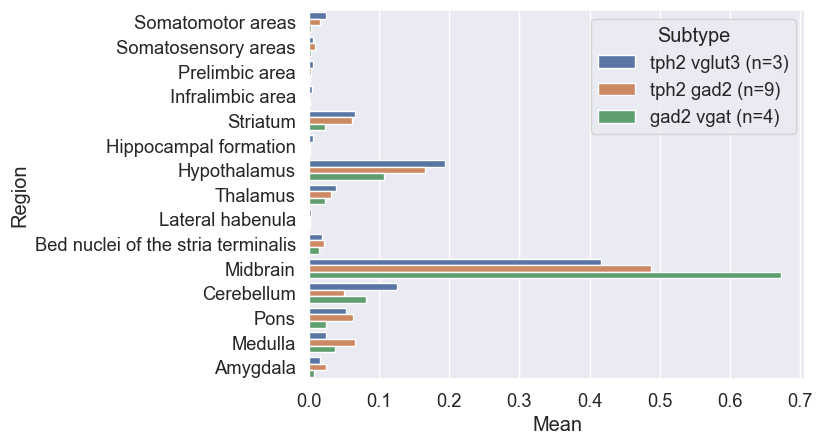

In [69]:
df_subtypes = []
df_regions = []
df_means = []


for subtype in ilrs.keys():
    mean = ilr_inv(np.mean(ilrs[subtype], axis=0))

    for region, mean in zip(regions, mean):
        df_regions.append(region)
        df_means.append(mean)
        df_subtypes.append(subtype)

data = {"Mean": df_means, "Subtype": df_subtypes, "Region": df_regions}

sns.barplot(x="Mean", y="Region", hue="Subtype", data = pd.DataFrame(data=data))
plt.show() 

### Plot PCA

In [88]:
X = []
data_subtypes = []
data_ids = []

for subtype in ilrs.keys():
    X += ilrs[subtype]
    data_subtypes += len(ilrs[subtype]) * [subtype]
    data_ids += ids_names[subtype]
X = np.array(X)

pca = PCA(n_components=2).fit(X)
X_new = pca.fit_transform(X)
vars = pca.explained_variance_ratio_
pc1_lbl = f"PC 1 ({vars[0]:.2f})"
pc2_lbl = f"PC 2 ({vars[1]:.2f})"
data = {pc1_lbl: X_new[:,0], pc2_lbl: X_new[:,1], "Subtype": data_subtypes, "ID": data_ids}
df = pd.DataFrame(data=data)


fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=300)
ax = sns.scatterplot(x=pc1_lbl, y=pc2_lbl, hue="Subtype", data = df, ax=ax)
for i,row in df.iterrows():
  ax.text(row[pc1_lbl], row[pc2_lbl],row["ID"], rotation=45)

# ax.set_xlim(-1.5, -0.5)
# ax.set_ylim(-1.5, -0.5)
#plt.show() 
plt.savefig("/Users/thomasathey/Desktop/test.svg", format="svg")

### How many more samples

In [18]:
from scipy.stats import mannwhitneyu, ttest_ind

for region in df.Region.unique():
    for i, subtype1 in enumerate(df.Subtype.unique()):
        for j, subtype2 in enumerate(df.Subtype.unique()[i+1:]):
            l1 = df[(df["Region"] == region) & (df["Subtype"] == subtype1)]["Percent of Total Inputs (%)"].tolist()
            l2 = df[(df["Region"] == region) & (df["Subtype"] == subtype2)]["Percent of Total Inputs (%)"].tolist()

            _, p = mannwhitneyu(l1, l2)
            for i in range(10):
                if p > 0.0047:
                    if len(l1) > len(l2):
                        l2.append(np.median(l2))
                    else:
                        l1.append(np.median(l1))
                else:
                    break
                
                _, p = mannwhitneyu(l1, l2)
            print(f"{region}: {subtype1} vs {subtype2}: need {i} more added")

Somatomotor areas: tph2 vglut3 (n=3) vs tph2 gad2 (n=9): need 9 more added
Somatomotor areas: tph2 vglut3 (n=3) vs gad2 vgat (n=4): need 6 more added
Somatomotor areas: tph2 gad2 (n=9) vs gad2 vgat (n=4): need 2 more added
Somatosensory areas: tph2 vglut3 (n=3) vs tph2 gad2 (n=9): need 9 more added
Somatosensory areas: tph2 vglut3 (n=3) vs gad2 vgat (n=4): need 9 more added
Somatosensory areas: tph2 gad2 (n=9) vs gad2 vgat (n=4): need 9 more added
Prelimbic area: tph2 vglut3 (n=3) vs tph2 gad2 (n=9): need 3 more added
Prelimbic area: tph2 vglut3 (n=3) vs gad2 vgat (n=4): need 5 more added
Prelimbic area: tph2 gad2 (n=9) vs gad2 vgat (n=4): need 6 more added
Infralimbic area: tph2 vglut3 (n=3) vs tph2 gad2 (n=9): need 2 more added
Infralimbic area: tph2 vglut3 (n=3) vs gad2 vgat (n=4): need 5 more added
Infralimbic area: tph2 gad2 (n=9) vs gad2 vgat (n=4): need 9 more added
Striatum: tph2 vglut3 (n=3) vs tph2 gad2 (n=9): need 9 more added
Striatum: tph2 vglut3 (n=3) vs gad2 vgat (n=4): 

In [ ]:
sd.region_barchart(regions, composite_regions=composite_regions, normalize_region=872)

### Within group Chi-sq

In [ ]:
subtype = "tph2 gad2"
regions = regions_coarse_part

subtype_brains = []
for brain_id in sd.brain_ids:
    if sd.brain2paths[brain_id]["subtype"] == subtype:
        subtype_brains.append(brain_id)

sd.region_graph

cont_table = np.zeros((len(subtype_brains),len(regions)))

for bi, brain_id in enumerate(subtype_brains):
    for ri, region in enumerate(regions):
        cont_table[bi, ri] = sd.region_graph.nodes[region][brain_id]

print(f"{np.sum(cont_table > 5)/cont_table.size} are > 5")
chi2_contingency(cont_table)[1]

In [ ]:
fig, ax = plt.subplots(1,1, dpi=300)
ax.pie(cont_table[0,:], labels=[sd.region_graph.nodes[r]["name"] for r in regions], textprops={'color':"w"})

### Chi-sq test and PCA

In [ ]:
brain2paths = sd.brain2paths
region_graph = sd.region_graph

data_mat = np.zeros((len(brain_ids), len(regions_coarse)))


subtype2idx = { "tph2 vglut3": 0,  "tph2 gad2": 1, "gad2 vgat": -1}

for bn, brain_id in enumerate(brain_ids):
    for rn, region in enumerate(regions_coarse):
        data_mat[bn, rn] = region_graph.nodes[region][brain_id]
        
random.shuffle(subtypes)

cont_table = np.zeros((len(regions_coarse), 2))
for bn, (brain_id, subtype) in enumerate(zip(brain_ids, subtypes)):
    subtype = brain2paths[brain_id]["subtype"]
    if subtype2idx[subtype] >= 0:
        cont_table[:, subtype2idx[subtype]] += data_mat[bn,:].T 



print(np.sum(cont_table > 5)/cont_table.size)
chi2_contingency(cont_table)

In [ ]:
brain2paths = sd.brain2paths
region_graph = sd.region_graph

data_mat = np.zeros((len(brain_ids), len(regions)))


for bn, brain_id in enumerate(brain_ids):
    for rn, region in enumerate(regions):
        data_mat[bn, rn] = region_graph.nodes[region][brain_id]/region_graph.nodes[997][brain_id]

pca = PCA(n_components=2)
X_2 = pca.fit_transform(data_mat)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": [brain2paths[brain_id]["subtype"] for brain_id in brain_ids],
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    sign = 2*(df_pca["PC 2"][i] > 0) - 1
    plt.text(
        x=df_pca["PC 1"][i] + 0.01,
        y=df_pca["PC 2"][i] + sign*0.001,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Input Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)
fig.set_figheight(10)
fig.set_figwidth(10)

### KL Div permutation test

In [ ]:
def get_dist(brain_id, regions, sd):
    total = sd.region_graph.nodes[997][brain_id]
    dist = []
    for region in regions:
        dist.append(sd.region_graph.nodes[region][brain_id])
    dist.append(total - np.sum(dist))

    return np.divide(dist, total)

In [ ]:
regions = regions_coarse_part
fig, axs = plt.subplots(1, 3)

for i, (stype1, stype2) in enumerate(
    zip(
        ["tph2 gad2", "tph2 gad2", "tph2 vglut3"],
        ["tph2 vglut3", "gad2 vgat", "gad2 vgat"],
    )
):
    ax = axs[i]
    brain_ids_stypes = []
    sz = 0
    dists = []

    for brain in brain_ids:
        if sd.brain2paths[brain]["subtype"] == stype1:
            dist = get_dist(brain, regions, sd)
            dists.append(dist)
            brain_ids_stypes.append(brain)
            sz += 1
    av_dist1 = np.mean(np.array(dists), axis=0)

    dists = []
    for brain in brain_ids:
        if sd.brain2paths[brain]["subtype"] == stype2:
            dist = get_dist(brain, regions, sd)
            dists.append(dist)
            brain_ids_stypes.append(brain)
    av_dist2 = np.mean(np.array(dists), axis=0)

    kl_div_true = np.sum(rel_entr(av_dist1, av_dist2)) + np.sum(
        rel_entr(av_dist2, av_dist1)
    )
    if not np.isfinite(kl_div_true) or kl_div_true < 0:
        print(f"Invalid distance between distributions: {av_dist1} and {av_dist2}")
    kl_divs = []

    for combo in tqdm(combinations(brain_ids_stypes, sz)):
        dists = []
        for brain in combo:
            dist = get_dist(brain, regions, sd)
            dists.append(dist)
        av_dist1 = np.mean(np.array(dists), axis=0)

        dists = []
        for brain in brain_ids:
            if brain not in combo:
                if (
                    sd.brain2paths[brain]["subtype"] == stype1
                    or sd.brain2paths[brain]["subtype"] == stype2
                ):
                    dist = get_dist(brain, regions, sd)
                    dists.append(dist)
        av_dist2 = np.mean(np.array(dists), axis=0)

        kl_div_c = np.sum(rel_entr(av_dist1, av_dist2)) + np.sum(
            rel_entr(av_dist2, av_dist1)
        )

        if not np.isfinite(kl_div_c) or kl_div_c < 0:
            print(f"Invalid distance between distributions: {av_dist1} and {av_dist2}")
        kl_divs.append(kl_div_c)

    p = np.sum(kl_divs > kl_div_true) / len(kl_divs)
    ax.hist(kl_divs)
    ax.plot([kl_div_true, kl_div_true], [0, 15], c="r", label=f"pval={p:.2f}")
    ax.set_title(f"{stype1} vs {stype2} w/{len(kl_divs)} permutations")
    ax.legend()
fig.set_figheight(5)
fig.set_figwidth(25)

### Hemisphere plots

In [ ]:
sample_data = []
region_data = []
left_count_data = []
right_count_data = []
gtypes = []

for region in regions:
    for brain in brain_ids:
        sample_data.append(brain)
        region_data.append(region)
        left_count_data.append(sd.region_graph_l.nodes[region][brain])
        right_count_data.append(sd.region_graph_r.nodes[region][brain])
        gtypes.append(sd.brain2paths[brain]["subtype"])
data = {
    "Sample": sample_data,
    "Region": region_data,
    "Somas Left": left_count_data,
    "Somas Right": right_count_data,
    "Subtype": gtypes,
}

df = pd.DataFrame(data=data)

In [ ]:
from scipy.stats import pearsonr

fig, axs = plt.subplots(3, 9)

for region, ax in zip(regions, axs.flatten()):
    for gtype in df["Subtype"].unique():
        df_r = df[df["Region"] == region]
        df_r = df_r[df_r["Subtype"] == gtype]
        graph = sns.regplot(data=df_r, x="Somas Left", y="Somas Right", ax=ax)
        r, p = pearsonr(df_r["Somas Left"], df_r["Somas Right"])
        txt = f'{sd.region_graph.nodes[region]["name"]}*: '  # f'{sd.region_graph.nodes[region]["name"]}: r={r:.2f}, p={p:.2f}'
        if p < 0.05:
            txt = txt + gtype
    ax.title.set_text(txt)


fig.set_figheight(15)
fig.set_figwidth(35)
plt.tight_layout()

## Create local volume

In [ ]:
vol = CloudVolume(
    "precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/Ch_647_iso"
)

In [ ]:
subvol = vol[256 * 11 : 256 * 12, 256 * 16 : 256 * 17, 256 * 6 : 256 * 7]

In [ ]:
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="image",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol.voxel_offset,
    chunk_size=vol.chunk_size,  # units are voxels
    volume_size=vol.volume_size,  # e.g. a cubic millimeter dataset
)

vol_ex = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example",
    info=info,
    compress=False,
)
vol_ex.commit_info()

In [ ]:
vol_ex[256 * 11 : 256 * 12, 256 * 16 : 256 * 17, 256 * 6 : 256 * 7] = subvol

In [ ]:
256 * 7

In [ ]:
vol = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/endogenous",
    fill_missing=True,
)

### Post detections to ng

In [ ]:
brain_id = "8606"
all_somas_pth = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/all_somas_{brain_id}.txt"

from brainlit.BrainLine.data.soma_data import brain2paths
from cloudreg.scripts.transform_points import NGLink
from cloudreg.scripts.visualization import create_viz_link_from_json

coords = []
coords_target_space = []
file1 = open(all_somas_pth, "r")
lines = file1.readlines()
for line in tqdm(lines, desc="parsing coordinates", leave=False):
    if line != "\n":
        line = " ".join(line.split())
        elements = line.split(",")
        coord = [elements[0][1:], elements[1], elements[2][:-1]]

        coords.append([float(e.strip()) for e in coord])

coords = coords[15000:]
print(f"{len(coords)} detections")

ng_link = brain2paths[brain_id]["val_info"]["url"]
viz_link = NGLink(ng_link.split("json_url=")[-1])
ngl_json = viz_link._json

ngl_json["layers"] = [
    layer for layer in ngl_json["layers"] if layer["type"] != "annotation"
]

ngl_json["layers"].append(
    {"type": "annotation", "points": coords, "name": "detected_somas"}
)
viz_link = create_viz_link_from_json(
    ngl_json, neuroglancer_link="https://viz.neurodata.io/?json_url="
)
print(f"Viz link with detections: {viz_link}")